In [1]:
import torch
import numpy
import math

In [2]:
elg_model = torch.load("./models/model-v0.1-(36, 60)-epoch-71-loss-18.0300.pth")
elg_model.eval()

ELG(
  (convPre): Conv(
    (conv): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (batchNorm2d): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residualBlockPre1): ResidualBlock(
    (convLow1): Conv(
      (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convLow2): Conv(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convLow3): Conv(
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (convUp): Conv(
      (conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
      (batchNorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track

In [3]:
eye_image_shape = (36, 60)

In [4]:
from src.datasources.unityeyes import UnityEyesDataset
val_root = "E:/Datasets/UnityEyes_Windows/800x600/val"
val_dataset = UnityEyesDataset(val_root, eye_image_shape=eye_image_shape, generate_heatmaps=True, random_difficulty=True)

In [5]:
import torch.utils.data as D
val_dataloader = D.DataLoader(val_dataset, batch_size=1)

In [6]:
entry = next(iter(val_dataloader))

In [7]:
eye_input = entry['eye'].cuda()

In [8]:
heatmaps_label = entry['heatmaps']
landmarks_label = entry['landmarks'].cuda()
radius_label = entry['radius'].cuda()
gaze_label = entry['gaze'].cuda()

In [9]:
heatmaps_predict, ldmks_predict, radius_predict, gaze_predict = elg_model(eye_input)

In [10]:
def compute_angular_loss(predict, label):
    """Pytorch method to calculate angular loss (via cosine similarity)"""
    def angle_to_unit_vectors(y):
        sin = torch.sin(y)
        cos = torch.cos(y)
        return torch.stack([
            cos[:, 0] * sin[:, 1],
            sin[:, 0],
            cos[:, 0] * cos[:, 1],
        ], dim=1)

    a = angle_to_unit_vectors(predict)
    b = angle_to_unit_vectors(label)
    ab = torch.sum(a*b, dim=1)
    a_norm = torch.sqrt(torch.sum(torch.square(a), dim=1))
    b_norm = torch.sqrt(torch.sum(torch.square(b), dim=1))
    cos_sim = ab / (a_norm * b_norm)
    cos_sim = torch.clip(cos_sim, -1.0 + 1e-6, 1.0 - 1e-6)
    ang = torch.acos(cos_sim) * 180. / math.pi
    return torch.mean(ang)

In [11]:
gaze_predict - gaze_label

tensor([[-0.0213, -0.0480]], device='cuda:0', grad_fn=<SubBackward0>)

In [12]:
compute_angular_loss(gaze_predict, gaze_label)

tensor(2.9374, device='cuda:0', grad_fn=<MeanBackward0>)

In [13]:
ldmks_predict - landmarks_label

tensor([[[-1.6394e-01, -5.0565e-01],
         [ 2.5970e-01, -1.2344e+00],
         [-6.9468e-02, -2.4552e-01],
         [ 1.0371e+00,  9.5463e-04],
         [ 6.7520e-01, -5.4850e-02],
         [ 6.4771e-01, -5.1672e-01],
         [ 3.3586e-01, -9.8356e-02],
         [-3.5706e-01, -4.3612e-01],
         [-2.3360e-01, -2.5629e-01],
         [-1.1814e-01, -2.0058e-01],
         [-1.3890e-01, -1.0849e-01],
         [ 1.3055e-01,  9.8217e-02],
         [ 3.7545e-01, -2.7433e-01],
         [-7.1373e-03,  5.5981e-01],
         [ 2.5747e-01,  1.8084e-01],
         [-9.1877e-02, -3.5385e-01],
         [ 1.5107e-01, -1.7091e-01],
         [-1.0197e-01, -4.2308e-01]]], device='cuda:0', grad_fn=<SubBackward0>)

In [14]:
radius_predict - radius_label

tensor([[-0.3462]], device='cuda:0', grad_fn=<SubBackward0>)

In [15]:
heatmaps_predict = heatmaps_predict.cpu()

In [16]:
heatmaps_predict.shape

torch.Size([1, 18, 36, 60])

In [17]:
heatmaps_predict = heatmaps_predict.detach().numpy()

In [18]:
heatmaps_predict[0][1]

array([[0.03561608, 0.03793153, 0.04064694, ..., 0.        , 0.        ,
        0.00651016],
       [0.03061256, 0.04093049, 0.03913145, ..., 0.        , 0.        ,
        0.00252937],
       [0.03113   , 0.04002592, 0.0364516 , ..., 0.        , 0.        ,
        0.00316416],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00071292],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00287378],
       [0.        , 0.        , 0.        , ..., 0.        , 0.00279908,
        0.00529366]], dtype=float32)

In [19]:
import numpy
sum_heatmaps = numpy.sum(heatmaps_predict, axis=1)

In [20]:
import matplotlib.pyplot as plt

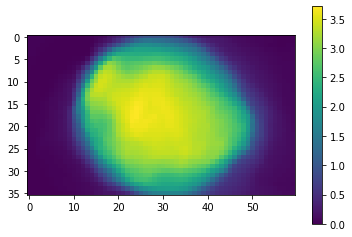

In [37]:
plt.figure()
plt.imshow(sum_heatmaps[0])
plt.colorbar()

In [22]:
def gaussian_2d(shape, centre, sigma=1.0):
    """Generate heatmap with single 2D gaussian."""
    # xs col
    xs = np.arange(0.5, shape[1] + 0.5, step=1.0, dtype=np.float32)
    # ys row
    ys = np.expand_dims(np.arange(0.5, shape[0] + 0.5, step=1.0, dtype=np.float32), -1)
    alpha = -0.5 / (sigma**2)
    heatmap = np.exp(alpha * ((xs - centre[0])**2 + (ys - centre[1])**2))
    return heatmap

def gaussian_2d_v2(shape, centre, sigma=1.0, visibility=2, scale=12):
    """Generate heatmap with single 2D gaussian."""
    height = int(shape[0])
    width = int(shape[1])
    heatmap = np.zeros(shape=(height, width))
    # this gaussian patch is 7x7, let's get four corners of it first
    x0 = int(centre[0])
    y0 = int(centre[1])
    xmin = int(x0 - 3 * sigma)
    ymin = int(y0 - 3 * sigma)
    xmax = int(x0 + 3 * sigma)
    ymax = int(y0 + 3 * sigma)
    if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
        return heatmap

    size = int(6 * sigma + 1)
    x, y = np.meshgrid(np.arange(0, size, 1), np.arange(0, size, 1), indexing='xy')

    # the center of the gaussian patch should be 1
    centre_x = size // 2
    centre_y = size // 2
    # generate this 7x7 gaussian patch (Gaussian function in 2D)
    alpha = -0.5 / (sigma**2)
    gaussian_patch = np.exp(alpha * ((x - centre_x)**2 + (y - centre_y)**2)) * scale

    # part of the patch could be out of the boundary, so we need to determine the valid range
    # if xmin = -2, it means the 2 left-most columns are invalid, which is max(0, -(-2)) = 2
    patch_xmin = np.maximum(0, -xmin)
    patch_ymin = np.maximum(0, -ymin)

    # if xmin = 59, xmax = 66, but our output is 64x64, then we should discard 2 right-most columns
    # which is min(64, 66) - 59 = 5, and column 6 and 7 are discarded
    patch_xmax = np.minimum(xmax, width) - xmin
    patch_ymax = np.minimum(ymax, height) - ymin

    # also, we need to determine where to put this patch in the whole heatmap
    heatmap_xmin = np.maximum(0, xmin)
    heatmap_ymin = np.maximum(0, ymin)
    heatmap_xmax = np.minimum(xmax, width)
    heatmap_ymax = np.minimum(ymax, height)

    heatmap[heatmap_ymin:heatmap_ymax, heatmap_xmin:heatmap_xmax] = \
        gaussian_patch[patch_ymin:patch_ymax,patch_xmin:patch_xmax]
    return heatmap

In [23]:
ldmks = ldmks_predict.cpu().detach().numpy()

In [24]:
ldmks = ldmks * 1

In [25]:
ldmks[0]

array([[13.635112 , 20.684881 ],
       [15.226189 , 12.6105385],
       [27.374292 ,  8.77277  ],
       [41.658745 , 15.045776 ],
       [47.71026  , 20.812145 ],
       [41.03322  , 24.370205 ],
       [27.54075  , 27.15618  ],
       [16.824492 , 24.548931 ],
       [15.420641 , 13.216845 ],
       [18.65965  ,  7.429389 ],
       [23.863613 ,  5.3188286],
       [28.398397 ,  8.253698 ],
       [29.45065  , 13.942    ],
       [25.944511 , 20.619312 ],
       [20.984396 , 22.442982 ],
       [16.369715 , 19.180132 ],
       [23.696692 , 14.1519165],
       [32.982075 , 17.766897 ]], dtype=float32)

In [32]:
import numpy as np
heatmaps = np.asarray([gaussian_2d(shape=(36, 60), centre=landmark, sigma=6.0) for landmark in ldmks[0]])

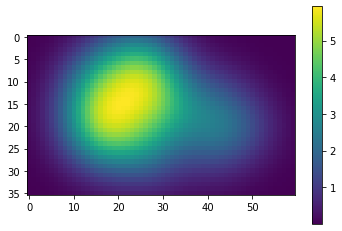

In [33]:
plt.figure()
plt.imshow(np.sum(heatmaps, axis=0))
plt.colorbar()

In [28]:
heatmaps_label = heatmaps_label.detach().numpy()

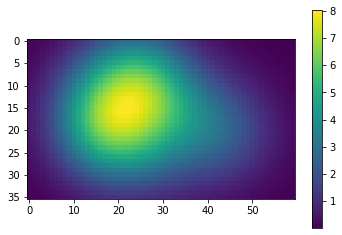

In [29]:
plt.figure()
plt.imshow(np.sum(heatmaps_label, axis=1)[0])
plt.colorbar()

In [30]:
eye = eye_input.cpu().detach().numpy()

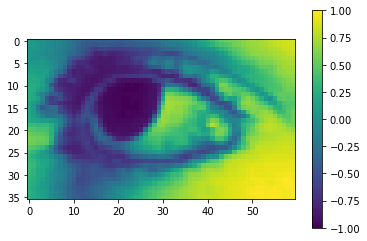

In [31]:
plt.figure()
plt.imshow(eye[0][0])
plt.colorbar()